<a href="https://colab.research.google.com/github/hernanullon/SynteticLoadCurves/blob/main/notebooks/Projeto_IA367_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto disciplina IA367


## Geração de cenários em sistemas de distribuição usando modelos generativos

### Integrantes: 


*  Hernán Ullón         
*  Karen Rosero
*  Luis Henrique Tenório







# Bibliotecas

In [1]:
import tensorflow as tf
import torch.nn as nn
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import os
import numpy as np
from numpy import genfromtxt

# Visualização dos dados

ID Transformador -->  medidores_5
Dimensao dados -->  (972, 96)


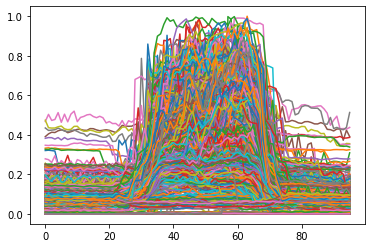

ID Transformador -->  medidores_0
Dimensao dados -->  (4434, 96)


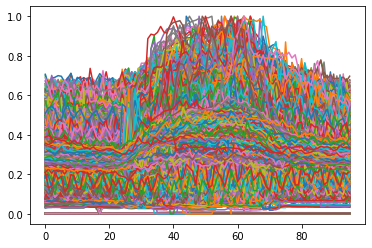

ID Transformador -->  medidores_1
Dimensao dados -->  (4078, 96)


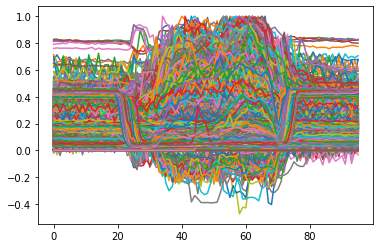

ID Transformador -->  medidores_7
Dimensao dados -->  (70, 96)


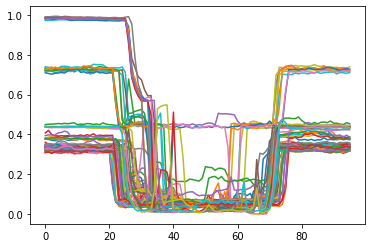

ID Transformador -->  medidores_6
Dimensao dados -->  (210, 96)


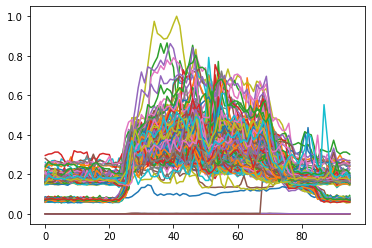

ID Transformador -->  medidores_8
Dimensao dados -->  (418, 96)


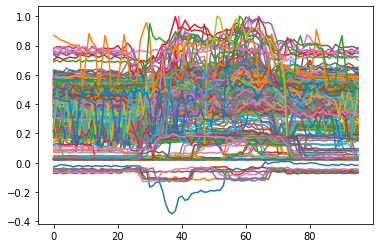

ID Transformador -->  medidores_10
Dimensao dados -->  (410, 96)


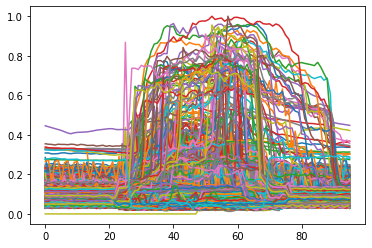

ID Transformador -->  medidores_9
Dimensao dados -->  (194, 96)


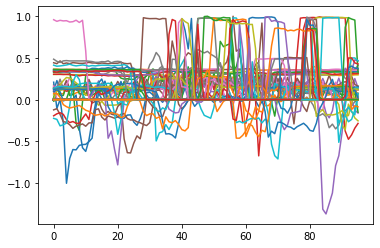

ID Transformador -->  medidores_2
Dimensao dados -->  (3056, 96)


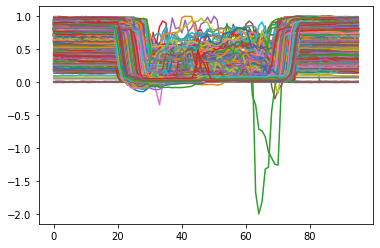

ID Transformador -->  medidores_3
Dimensao dados -->  (238, 96)


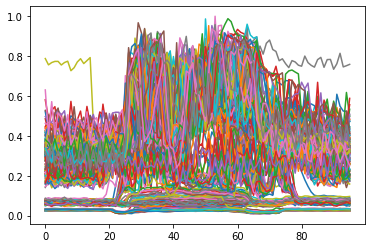

ID Transformador -->  medidores_4
Dimensao dados -->  (811, 96)


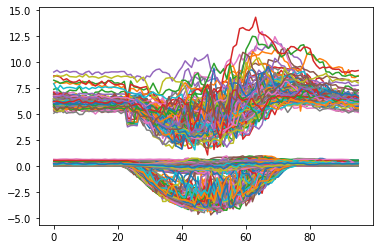

In [2]:
_dir = "/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/banco de dados v3/classes/"

for filename in os.listdir(_dir):
  plt.figure()
  my_data = genfromtxt(os.path.join(_dir, filename), delimiter=',')
  print('ID Transformador --> ', filename[:-4])
  if len(my_data.shape) == 2:
    my_data = my_data[1:,1:]
    print('Dimensao dados --> ', my_data.shape)
    for i in range(my_data.shape[0]):
      plt.plot(my_data[i])
    plt.show()  

Por enquanto, selecionamos os transformadores com melhor comportamento, os medidores 0, 2, 5, 7. 

# Declaração dos dados para cada transformador

In [3]:
_dir = "/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/banco de dados v3/classes/"
_dir2 = "/content/drive/MyDrive/Especial/IA376/Syntetic_Load_Curves/banco de dados v3/classes/"

transf_ok = ["medidores_0.csv","medidores_1.csv","medidores_2.csv","medidores_5.csv", "medidores_7.csv"]

#Transformador 0
data_0 = genfromtxt(os.path.join(_dir2, transf_ok[0]), delimiter=',')
data_0 = data_0[1:,1:]     
print("Transformador 0", data_0.shape)   
# separo em treino e teste com o 70% dos dados para treinamento e o 30% para validação
x0_train = data_0[:int(np.rint(data_0.shape[0]*0.7))]
x0_test = data_0[int(np.rint(data_0.shape[0]*0.7)):]

#Transformador 1
data_1 = genfromtxt(os.path.join(_dir2, transf_ok[1]), delimiter=',')
data_1 = data_1[1:,1:]     
print("Transformador 1", data_1.shape)   
# separo em treino e teste com o 70% dos dados para treinamento e o 30% para validação
x1_train = data_1[:int(np.rint(data_1.shape[0]*0.7))]
x1_test = data_1[int(np.rint(data_1.shape[0]*0.7)):]

#Transformador 2
data_2 = genfromtxt(os.path.join(_dir, transf_ok[2]), delimiter=',')
data_2 = data_2[1:,1:]     
print("Transformador 2", data_2.shape)  
x2_train = data_2[:int(np.rint(data_2.shape[0]*0.7))]
x2_test = data_2[int(np.rint(data_2.shape[0]*0.7)):]

#Transformador 5
data_5 = genfromtxt(os.path.join(_dir, transf_ok[3]), delimiter=',')
data_5 = data_5[1:,1:]     
print("Transformador 5", data_5.shape)  
x5_train = data_5[:int(np.rint(data_5.shape[0]*0.7))]
x5_test = data_5[int(np.rint(data_5.shape[0]*0.7)):]

#Transformador 7
data_7 = genfromtxt(os.path.join(_dir, transf_ok[4]), delimiter=',')
data_7 = data_7[1:,1:]     
print("Transformador 7", data_7.shape) 
x7_train = data_7[:int(np.rint(data_7.shape[0]*0.7))]
x7_test = data_7[int(np.rint(data_7.shape[0]*0.7)):] 

Transformador 0 (4434, 96)
Transformador 1 (4078, 96)
Transformador 2 (3056, 96)
Transformador 5 (972, 96)
Transformador 7 (70, 96)


# Classes e funções do modelo 

In [4]:
class Shuffle(Layer):
    #A camada de embaralhamento fornece duas maneiras de embaralhar a dimensão de entrada:
    #Um é inversão direta, o outro é aleatório, o padrão é inverter diretamente a dimensão
    
    def __init__(self, idxs=None, mode='reverse', **kwargs):
        super(Shuffle, self).__init__(**kwargs)
        self.idxs = idxs
        self.mode = mode
    def call(self, inputs):
        v_dim = K.int_shape(inputs)[-1]
        if self.idxs == None:
            self.idxs = list(range(v_dim))
            if self.mode == 'reverse':
                self.idxs = self.idxs[::-1]
            elif self.mode == 'random':
                np.random.shuffle(self.idxs)
        inputs = K.transpose(inputs)
        outputs = K.gather(inputs, self.idxs)
        outputs = K.transpose(outputs)
        return outputs
    def inverse(self):
        v_dim = len(self.idxs)
        _ = sorted(zip(range(v_dim), self.idxs), key=lambda s: s[1])
        reverse_idxs = [i[0] for i in _]
        return Shuffle(reverse_idxs)


class SplitVector(Layer):
    #Particionar a entrada em duas partes, intercalar as partições
    def __init__(self, **kwargs):
        super(SplitVector, self).__init__(**kwargs)
    def call(self, inputs):
        v_dim = K.int_shape(inputs)[-1]
        inputs = K.reshape(inputs, (-1, v_dim//2, 2))
        return [inputs[:,:,0], inputs[:,:,1]]
    def compute_output_shape(self, input_shape):
        v_dim = input_shape[-1]
        return [(None, v_dim//2), (None, v_dim//2)]
    def inverse(self):
        layer = ConcatVector()
        return layer

class ConcatVector(Layer):
    #Mescle novamente as duas partes da partição
    def __init__(self, **kwargs):
        super(ConcatVector, self).__init__(**kwargs)
    def call(self, inputs):
        inputs = [K.expand_dims(i, 2) for i in inputs]
        inputs = K.concatenate(inputs, 2)
        return K.reshape(inputs, (-1, np.prod(K.int_shape(inputs)[1:])))
    def compute_output_shape(self, input_shape):
        return (None, sum([i[-1] for i in input_shape]))
    def inverse(self):
        layer = SplitVector()
        return layer


class AddCouple(Layer):
    #camada de acoplamento aditivo
    def __init__(self, isinverse=False, **kwargs):
        self.isinverse = isinverse
        super(AddCouple, self).__init__(**kwargs)
    def call(self, inputs):
        part1, part2, mpart1 = inputs
        if self.isinverse:
            return [part1, part2 + mpart1] # 逆为加 inverso para mais
        else:
            return [part1, part2 - mpart1] # 正为减 positivo para menos
    def compute_output_shape(self, input_shape): 
        return [input_shape[0], input_shape[1]]
    def inverse(self):
        layer = AddCouple(True)
        return layer


class Scale(Layer):
    # camada de escalamento
    def __init__(self, **kwargs):
        super(Scale, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1, input_shape[1]),
                                      initializer='glorot_normal',
                                      trainable=True)
    def call(self, inputs):
        self.add_loss(-K.sum(self.kernel)) # 对数行列式
        return K.exp(self.kernel) * inputs
    def inverse(self):
        scale = K.exp(-self.kernel)
        return Lambda(lambda x: scale * x)


def build_basic_model(v_dim):
    #O modelo base, ou seja, m na camada de acoplamento aditivo
    _in = Input(shape=(v_dim,))
    _ = _in
    for i in range(5):
        _ = Dense(500, activation='relu')(_)
    _ = Dense(v_dim, activation='relu')(_)
    return Model(_in, _)



# Transformador 2

Instancias encoder

In [5]:
shuffle1 = Shuffle()
shuffle2 = Shuffle()
shuffle3 = Shuffle()
shuffle4 = Shuffle()

split = SplitVector()
couple = AddCouple()
concat = ConcatVector()
scale = Scale()

original_dim = 96

basic_model_1 = build_basic_model(original_dim//2)
basic_model_2 = build_basic_model(original_dim//2)
basic_model_3 = build_basic_model(original_dim//2)
basic_model_4 = build_basic_model(original_dim//2)


x_in = Input(shape=(original_dim,))
x = x_in


# Adicione ruído negativo à entrada

x = Lambda(lambda s: K.in_train_phase(s-0.01*K.random_uniform(K.shape(s)), s))(x)

x = shuffle1(x)
x1,x2 = split(x)
mx1 = basic_model_1(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle2(x)
x1,x2 = split(x)
mx1 = basic_model_2(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle3(x)
x1,x2 = split(x)
mx1 = basic_model_3(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle4(x)
x1,x2 = split(x)
mx1 = basic_model_4(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = scale(x)

In [6]:
encoder2 = Model(x_in, x)
encoder2.summary()
encoder2.compile(loss=lambda y_true, y_pred: K.sum(0.5 * y_pred**2, 1),
                optimizer='adam')

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 96)]         0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 96)           0           input_5[0][0]                    
__________________________________________________________________________________________________
shuffle (Shuffle)               (None, 96)           0           lambda[0][0]                     
__________________________________________________________________________________________________
split_vector (SplitVector)      [(None, 48), (None,  0           shuffle[0][0]                    
                                                                 shuffle_1[0][0]            

Treinamento do encoder

In [7]:
encoder2.fit(x2_train,
            x2_train,
            batch_size=128,
            epochs=400,
            validation_data=(x2_test, x2_test))

Epoch 1/400


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_4/shuffle_3/Reshape_1:0", shape=(96,), dtype=int32), values=Tensor("gradient_tape/model_4/shuffle_3/Reshape:0", shape=(96, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_4/shuffle_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_4/shuffle_2/Reshape_1:0", shape=(96,), dtype=int32), values=Tensor("gradient_tape/model_4/shuffle_2/Reshape:0", shape=(96, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_4/shuffle_2/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of

17/17 [==============================] - 4s 45ms/step - loss: 1.8365 - val_loss: -0.3334
Epoch 2/400
17/17 [==============================] - 0s 18ms/step - loss: -1.6727 - val_loss: -2.4656
Epoch 3/400
17/17 [==============================] - 0s 17ms/step - loss: -3.5186 - val_loss: -4.8079
Epoch 4/400
17/17 [==============================] - 0s 18ms/step - loss: -5.6679 - val_loss: -6.5996
Epoch 5/400
17/17 [==============================] - 0s 19ms/step - loss: -7.4237 - val_loss: -8.2893
Epoch 6/400
17/17 [==============================] - 0s 22ms/step - loss: -9.1009 - val_loss: -9.9838
Epoch 7/400
17/17 [==============================] - 0s 17ms/step - loss: -10.7951 - val_loss: -11.6646
Epoch 8/400
17/17 [==============================] - 0s 21ms/step - loss: -12.3855 - val_loss: -13.2238
Epoch 9/400
17/17 [==============================] - 0s 19ms/step - loss: -14.0686 - val_loss: -14.9455
Epoch 10/400
17/17 [==============================] - 0s 16ms/step - loss: -15.7485 - val

Instancias decoder

In [8]:
# Construir o modelo inverso (gerar o modelo) e realizar todas as operações 
# no sentido inverso

x = x_in
x = scale.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_4(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle4.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_3(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle3.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_2(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle2.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_1(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle1.inverse()(x)

decoder2 = Model(x_in, x)

Geração de amostras novas 

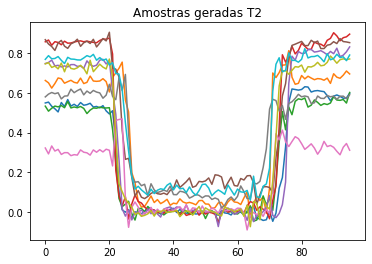

In [11]:
n_amostras = 10
output_size = 96
samples_2 = []

for i in range(n_amostras):
      z_sample = np.array(np.random.randn(1, output_size)) * 0.75 
      #O desvio padrão leva 0,75
      x_decoded = decoder2.predict(z_sample)
      samples_2.append(x_decoded)

plt.figure()
for i in range(n_amostras):
  plt.plot(samples_2[i][0])
plt.title("Amostras geradas T2")
plt.show()

Text(0.5, 1.0, 'Amostra original T2')

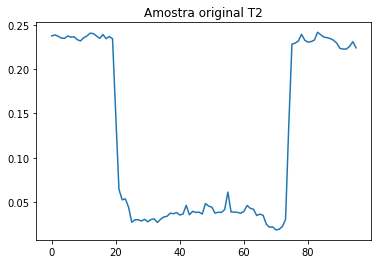

In [15]:
plt.figure()
plt.plot(x2_train[0])
plt.title("Amostra original T2")

# Transformador 5

Instancias encoder

In [32]:
shuffle1 = Shuffle()
shuffle2 = Shuffle()
shuffle3 = Shuffle()
shuffle4 = Shuffle()

split = SplitVector()
couple = AddCouple()
concat = ConcatVector()
scale = Scale()

original_dim = 96

basic_model_1 = build_basic_model(original_dim//2)
basic_model_2 = build_basic_model(original_dim//2)
basic_model_3 = build_basic_model(original_dim//2)
basic_model_4 = build_basic_model(original_dim//2)


x_in = Input(shape=(original_dim,))
x = x_in

In [33]:
# Adicione ruído negativo à entrada
x = Lambda(lambda s: K.in_train_phase(s-0.01*K.random_uniform(K.shape(s)), s))(x)

x = shuffle1(x)
x1,x2 = split(x)
mx1 = basic_model_1(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle2(x)
x1,x2 = split(x)
mx1 = basic_model_2(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle3(x)
x1,x2 = split(x)
mx1 = basic_model_3(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle4(x)
x1,x2 = split(x)
mx1 = basic_model_4(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = scale(x)

encoder5 = Model(x_in, x)
encoder5.summary()
encoder5.compile(loss=lambda y_true, y_pred: K.sum(0.5 * y_pred**2, 1),
                optimizer='adam')

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 96)]         0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 96)           0           input_15[0][0]                   
__________________________________________________________________________________________________
shuffle_16 (Shuffle)            (None, 96)           0           lambda_5[0][0]                   
__________________________________________________________________________________________________
split_vector_10 (SplitVector)   [(None, 48), (None,  0           shuffle_16[0][0]                 
                                                                 shuffle_17[0][0]          

Treinamento do encoder

In [34]:
encoder5.fit(x5_train,
            x5_train,
            batch_size=128,
            epochs=600,
            validation_data=(x5_test, x5_test))

Epoch 1/600


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_17/shuffle_19/Reshape_1:0", shape=(96,), dtype=int32), values=Tensor("gradient_tape/model_17/shuffle_19/Reshape:0", shape=(96, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_17/shuffle_19/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_17/shuffle_18/Reshape_1:0", shape=(96,), dtype=int32), values=Tensor("gradient_tape/model_17/shuffle_18/Reshape:0", shape=(96, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_17/shuffle_18/Cast:0", shape=(2,), dtype=int32))) to a den

6/6 [==============================] - 3s 126ms/step - loss: -0.3008 - val_loss: -1.5604
Epoch 2/600
6/6 [==============================] - 0s 22ms/step - loss: -1.6854 - val_loss: -2.2680
Epoch 3/600
6/6 [==============================] - 0s 21ms/step - loss: -2.4196 - val_loss: -2.9119
Epoch 4/600
6/6 [==============================] - 0s 16ms/step - loss: -3.0564 - val_loss: -3.5307
Epoch 5/600
6/6 [==============================] - 0s 20ms/step - loss: -3.6626 - val_loss: -4.1047
Epoch 6/600
6/6 [==============================] - 0s 20ms/step - loss: -4.2650 - val_loss: -4.6939
Epoch 7/600
6/6 [==============================] - 0s 19ms/step - loss: -4.8532 - val_loss: -5.2792
Epoch 8/600
6/6 [==============================] - 0s 42ms/step - loss: -5.4383 - val_loss: -5.8557
Epoch 9/600
6/6 [==============================] - 0s 34ms/step - loss: -6.0292 - val_loss: -6.4423
Epoch 10/600
6/6 [==============================] - 0s 37ms/step - loss: -6.6155 - val_loss: -7.0283
Epoch 11/6

Instancias decoder

In [35]:
# Construir o modelo inverso (gerar o modelo) e realizar todas as operações 
# no sentido inverso

x = x_in
x = scale.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_4(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle4.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_3(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle3.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_2(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle2.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_1(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle1.inverse()(x)

decoder5 = Model(x_in, x)

Geração de amostras novas 

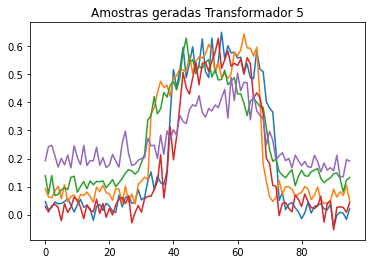

In [40]:
n_amostras = 5
output_size = 96
samples_5 = []

for i in range(n_amostras):
      z_sample = np.array(np.random.randn(1, output_size)) * 0.75 
      #O desvio padrão leva 0,75 em vez de 1
      x_decoded = decoder5.predict(z_sample)
      samples_5.append(x_decoded)

plt.figure()
for i in range(n_amostras):
  plt.plot(samples_5[i][0])
plt.title("Amostras geradas Transformador 5")
plt.show()

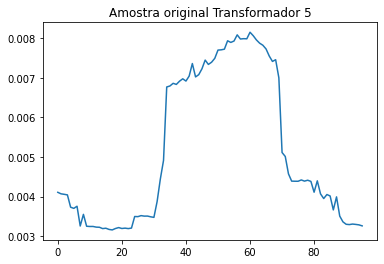

In [42]:
plt.figure()
plt.plot(x5_train[5])
plt.title("Amostra original Transformador 5")
plt.show()